<table class="table">
<thead>
<tr>
<th> Indice </th>
<td> 0 </td>
<td> 1 </td>
<td> 2 </td>
<td> 3 </td>
<td> 4 </td>
<td> 5 </td>
<td> 6 </td>
<td> 7 </td>
<td> 8 </td>
<td> 9 </td>
<td> 10 </td>
<td> 11 </td>
<td> 12 </td>
<td> 13 </td>
<td> 14 </td>
<td> 15 </td>
<td> 16 </td>
</tr>
</thead>

<tbody>
<tr>
<th> Posicion </th>
<td> Right <br>eye </td>
<td> Left <br>eye </td>
<td> Nose </td>
<td> Head </td>
<td> Neck </td>
<td> Right <br>shoulder </td>
<td> Right <br>elbow </td>
<td> Right <br>wrist </td>
<td> Left <br>shoulder </td>
<td> Left <br>elbow </td>
<td> Left <br>wrist </td>
<td> Hip </td>
<td> Right <br>knee </td>
<td> Right <br>ankle </td>
<td> Left <br>knee </td>
<td> Left <br>ankle </td>
<td> Tail </td>
</tr>
</tbody>

</table>

In [52]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

from skimage import io, transform

import json
import os
import random

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib.collections import LineCollection

import seaborn as sns

from itertools import chain
import operator

plt.ion()

In [29]:
!pip install kaggle
!mkdir ~/.kaggle
!pip install opendatasets
import opendatasets as od

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [30]:
def set_device():

  device = "cuda" if torch.cuda.is_available() else "cpu"
  return device

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


In [31]:
DEVICE = set_device()
set_seed(775,755)

# Funciones

In [32]:
def clean_data(data_list):
  for i in range(len(data_list)):

    bbox = data_list[i]['bbox']
    bb_x1 = int(bbox[0])
    bb_y1 = int(bbox[1])

    data_list[i].pop('visibility',None)

    x, y = data_list[i]['landmarks'][0::2], data_list[i]['landmarks'][1::2]

    x = np.array(x) - bb_x1
    y = np.array(y) - bb_y1

    land = np.array([x,y]).T.flatten()

    data_list[i].update({'landmarks':land})

  return data_list

In [33]:
connections = [[0,2],[2,1],[3,4],[4,5],[5,6],[6,7],[4,8],[8,9],[9,10],[4,11],[11,12],[12,13],[11,14],[14,15],[11,16]]

def brid_pl(landmarks):

  landmarks = np.reshape(landmarks,(-1,2)).tolist()
  connec = []
  for j, k in connections:
    connec.append([landmarks[j],landmarks[k]])
  connec_pl = chain(*np.array(connec).transpose((0,2,1)).tolist())

  return np.array(connec).astype('float'), connec_pl

Plot Function

In [56]:
%matplotlib inline
def plot_raw(data, index=0):
    bbox = data.loc[index, 'bbox']
    bb_x1 = int(bbox[0])
    bb_y1 = int(bbox[1])
    bb_x2 = int(bbox[0] + bbox[2])
    bb_y2 = int(bbox[1] + bbox[3])

    #Plotting
    image = mpimg.imread(data.loc[index,'file'])
    image = image[bb_y1:bb_y2,bb_x1:bb_x2]
    maxim = max(image.shape[1], image.shape[0])

    plt.rc('figure', figsize=[13*image.shape[1]/(maxim), 8*image.shape[0]/(maxim)], dpi=90)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    subplot_dim = (1,2)

    x, y = np.reshape(data.loc[index,'landmarks'],(-1,2)).astype('float').transpose()
    br , br_plot = brid_pl(data.loc[index,'landmarks'])

    ax1 = plt.subplot2grid(subplot_dim, (0, 1), aspect="equal")
    ax0 = plt.subplot2grid(subplot_dim, (0, 0), aspect="equal", adjustable='box', sharex=ax1, sharey=ax1)

    lc = mc.LineCollection(br, linewidths=3)
    ax0.add_collection(lc)
    ax0.autoscale()
    ax0.scatter(x,y,s=8**2,c='red')

    ax1.imshow(image)
    ax1.scatter(x,y,s=7**2,c='red')
    ax1.plot(*br_plot, color="royalblue", linewidth=2)

    plt.tight_layout()
    plt.show()

def plot_DS(data, index):
    image = data[index]['image']
    maxim = max(image.shape[1], image.shape[2])

    plt.rc('figure', figsize=[13*image.shape[2]/maxim, 8*image.shape[1]/maxim], dpi=90)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    subplot_dim = (1, 2)

    x, y = torch.reshape(data[index]['landmarks'], (-1, 2)).t()
    br, br_plot = brid_pl(data[index]['landmarks'].detach().numpy())

    ax1 = plt.subplot2grid(subplot_dim, (0, 1), aspect="equal")
    ax0 = plt.subplot2grid(subplot_dim, (0, 0), aspect="equal", adjustable='box', sharex=ax1, sharey=ax1)

    lc = LineCollection(br, linewidths=3)
    ax0.add_collection(lc)
    ax0.autoscale()
    ax0.scatter(x, y, s=8**2, c='red')

    ax1.imshow(image.permute(1, 2, 0))
    ax1.scatter(x, y, s=7**2, c='red')
    ax1.plot(*br_plot, color="royalblue", linewidth=2)

    fig.suptitle("Reescalado", fontsize=25, y=0.9)

    plt.tight_layout()
    plt.show()

# Cargar datos (Kaggle)

In [9]:
# 6e437ab5c45ea1dcc33121b6082abeed
path = 'https://www.kaggle.com/datasets/danielchang2002/openmonkeychallenge'
od.download(path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: axelflp
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/danielchang2002/openmonkeychallenge


100%|██████████| 12.1G/12.1G [02:08<00:00, 102MB/s]


# Procesamiento de datos

In [10]:
with open('/content/openmonkeychallenge/train_annotation.json', 'r') as f:
  train_ann = json.load(f)
train_ann = train_ann['data']
size_train = len(train_ann)

with open('/content/openmonkeychallenge/val_annotation.json', 'r') as f:
  test_ann = json.load(f)
test_ann = test_ann['data']
size_test = len(test_ann)


print('Tamaño del conjunto de entrenamiento:\t',size_train)
print('Tamaño del conjunto de validación:\t',size_test)

Tamaño del conjunto de entrenamiento:	 66917
Tamaño del conjunto de validación:	 22306


In [11]:
train_ann = clean_data(train_ann)
test_ann = clean_data(test_ann)
especies = list(set(map(operator.itemgetter('species'), train_ann)).union(set(map(operator.itemgetter('species'), test_ann))))

In [12]:
train_d = pd.DataFrame(train_ann)
test_d = pd.DataFrame(test_ann)
train_d['file'] = '/content/openmonkeychallenge/train/train/'+train_d['file']
test_d['file'] = '/content/openmonkeychallenge/val/val/'+test_d['file']

<ipython-input-43-8d736842fe9d>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(subplot_dim, (0, 1), aspect="equal")
<ipython-input-43-8d736842fe9d>:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid(subplot_dim, (0, 0), aspect="equal", adjustable='box', sharex=ax1, sharey=ax1)


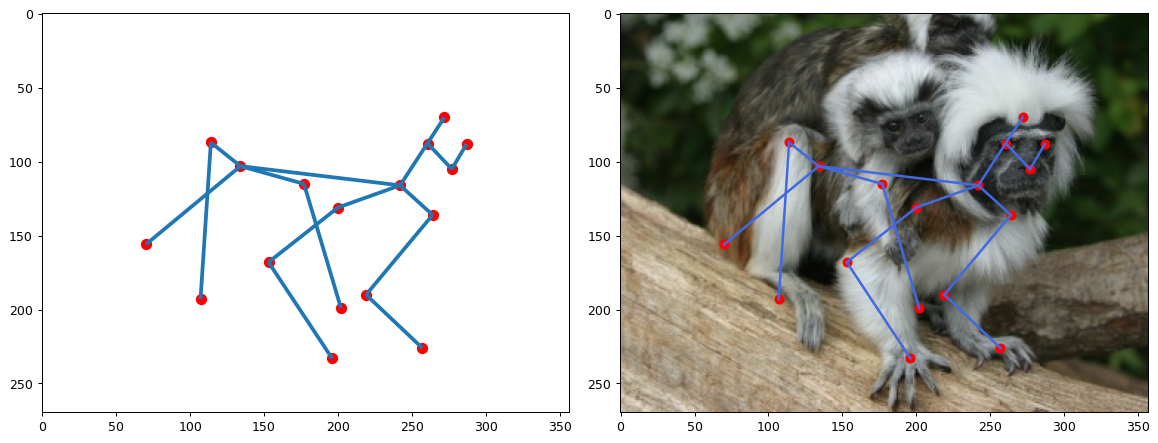

In [44]:
plot_raw(train_d, 159)

## Crear Dataset

In [14]:
class Landmarks_Dataset(Dataset):

  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    if torch.is_tensor(index):
            idx = idx.tolist()
    #Para ajustar margenes de la imagen
    bbox = self.dataset.loc[index, 'bbox']
    bb_x1 = int(bbox[0])
    bb_y1 = int(bbox[1])
    bb_x2 = int(bbox[0] + bbox[2])
    bb_y2 = int(bbox[1] + bbox[3])

    img_name = os.path.join(self.dataset.loc[index, 'file'])
    image = io.imread(img_name)
    image = image[bb_y1:bb_y2,bb_x1:bb_x2]
    specie, fil = self.dataset.loc[index,'species'], self.dataset.loc[index,'file']
    landmarks = self.dataset.loc[index, 'landmarks']
    landmarks = landmarks.astype('float').flatten()
    sample = {'image': image, 'landmarks': landmarks}

    sample.update({'species': specie, 'file':fil})

    if self.transform:
      sample = self.transform(sample)

    return sample

class Rescale(object):

  def __init__(self, output_size):

    assert isinstance(output_size, (int, tuple))

    self.output_size = output_size

  def __call__(self, sample):
    image, landmarks, specie, fil = sample.values()

    h, w = image.shape[:2]

    if isinstance(self.output_size, int):
      new_h, new_w = self.output_size, self.output_size
    else:
      new_h, new_w = self.output_size
    new_h, new_w = int(new_h), int(new_w)

    img = transform.resize(image,(new_h,new_w))

    landmarks = (landmarks.reshape((-1,2))*[new_w/w, new_h/h]).flatten()

    return {'image':img,
            'landmarks':landmarks,
            'species':specie,
            'file':fil}

class ToTensor(object):

  def __call__(self, sample):
    image, landmarks, specie, fil = sample.values()

    img = image.transpose((2,0,1))
    return {'image':torch.from_numpy(img),
            'landmarks':torch.from_numpy(landmarks),
            'species':specie,
            'file':fil}

In [38]:
train_data = Landmarks_Dataset(train_d, transform=transforms.Compose([Rescale(200),
                                                                      ToTensor()]))
test_data = Landmarks_Dataset(test_d, transform=transforms.Compose([Rescale(200),
                                                                      ToTensor()]))

<ipython-input-56-8b3e256e897e>:78: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(subplot_dim, (0, 1), aspect="equal")
<ipython-input-56-8b3e256e897e>:79: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid(subplot_dim, (0, 0), aspect="equal", adjustable='box', sharex=ax1, sharey=ax1)


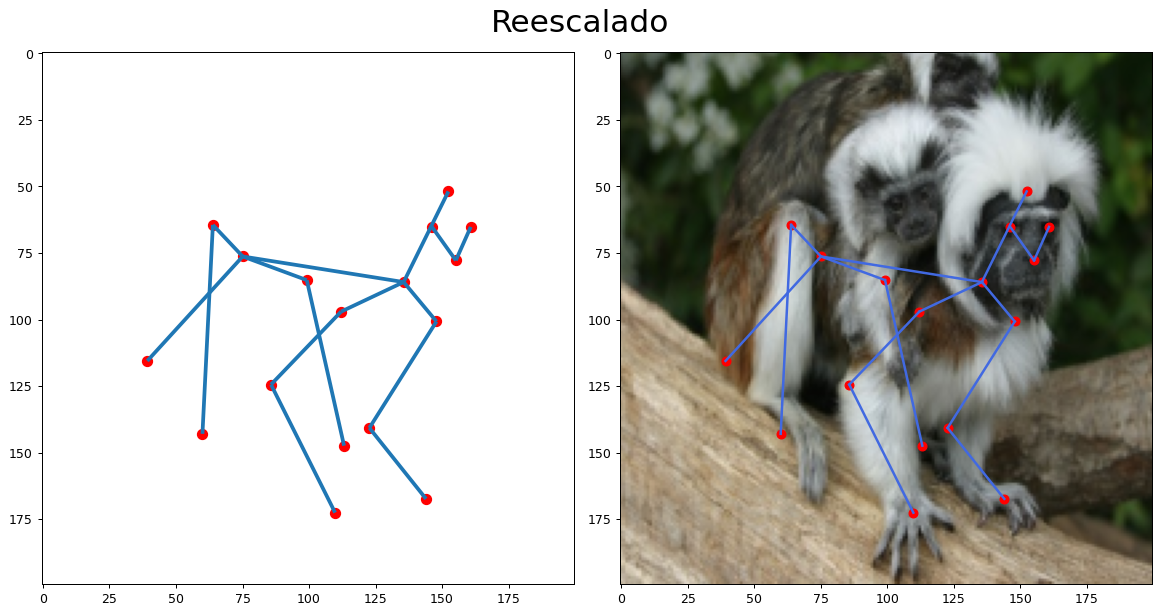

In [57]:
plot_DS(train_data, 159)

# U-NET
Implementation

In [19]:
class DoubleConv(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()
    mid_channels = out_channels
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, bias=True, dtype=torch.float64),
        nn.BatchNorm2d(mid_channels, dtype=torch.float64),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, bias=True, dtype=torch.float64),
        nn.BatchNorm2d(out_channels, dtype=torch.float64),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.double_conv(x)

class Down(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.Max_Pool = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, out_channels)
    )

  def forward(self, x):
    return self.Max_Pool(x)

class Up(nn.Module):

  def __init__(self, in_channels):
    super().__init__()
    self.Ups = nn.ConvTranspose2d(in_channels, in_channels//2, 2, stride=2, dtype=torch.float64)
    self.conv = DoubleConv(in_channels, in_channels//2)

  def forward(self, x1, x2):
    x1 = self.Ups(x1)
    crp = transforms.CenterCrop((x1.shape[-2],x1.shape[-1]))
    x2 = crp(x2)

    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)



In [22]:
class UNet_pred(nn.Module):

  def __init__(self):
    super().__init__()
    #U-Net
    self.D1 = DoubleConv(3, 64)
    self.D2 = Down(64, 128)
    self.D3 = Down(128, 256)
    self.D4 = Down(256, 512)
    self.U1 = Up(512)
    self.U2 = Up(256)
    self.U3 = Up(128)
    self.U4 = nn.Conv2d(64, 2, 1, dtype=torch.float64)

    self.mlp = nn.Sequential(
      nn.Flatten(),
      nn.Linear(23328, 5000, dtype=torch.float64),
      nn.LeakyReLU(negative_slope=0.5, inplace=True),
      nn.Linear(5000, 500, dtype=torch.float64),
      nn.LeakyReLU(negative_slope=0.5, inplace=True),
      nn.Linear(500, 34, dtype=torch.float64),
      nn.Sigmoid()
    )

  def forward(self, x):
    x1 = self.D1(x)
    x2 = self.D2(x1)
    x3 = self.D3(x2)
    x4 = self.D4(x3)
    x5 = self.U1(x4, x3)
    x6 = self.U2(x5, x2)
    x7 = self.U3(x6, x1)
    x8 = self.U4(x7)
    x9 = self.mlp(x8)

    return x9*200

In [23]:
U = UNet_pred().to(device = DEVICE)

with open('U2.pt', 'rb') as f:
    U3  = torch.load(f)
U.load_state_dict(U3)

<All keys matched successfully>

# Predecition

In [26]:
im1 = test_data[198]['image']
im2 = test_data[135]['image']
im3 = test_data[753]['image']

lm1 = test_data[198]['landmarks']
lm2 = test_data[135]['landmarks']
lm3 = test_data[753]['landmarks']

pl = [[im1,lm1],[im2,lm2],[im3,lm3]]

pred = U(torch.stack([im1,im2,im3]).to(DEVICE))
plm1 = pred[0].detach().cpu()
plm2 = pred[1].detach().cpu()
plm3 = pred[2].detach().cpu()
predl = [[im1,plm1],[im2,plm2],[im3,plm3]]

<ipython-input-27-65767773622f>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(subplot_dim, (0, 1), aspect="equal")
<ipython-input-27-65767773622f>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid(subplot_dim, (0, 0), aspect="equal", adjustable='box', sharex=ax1, sharey=ax1)


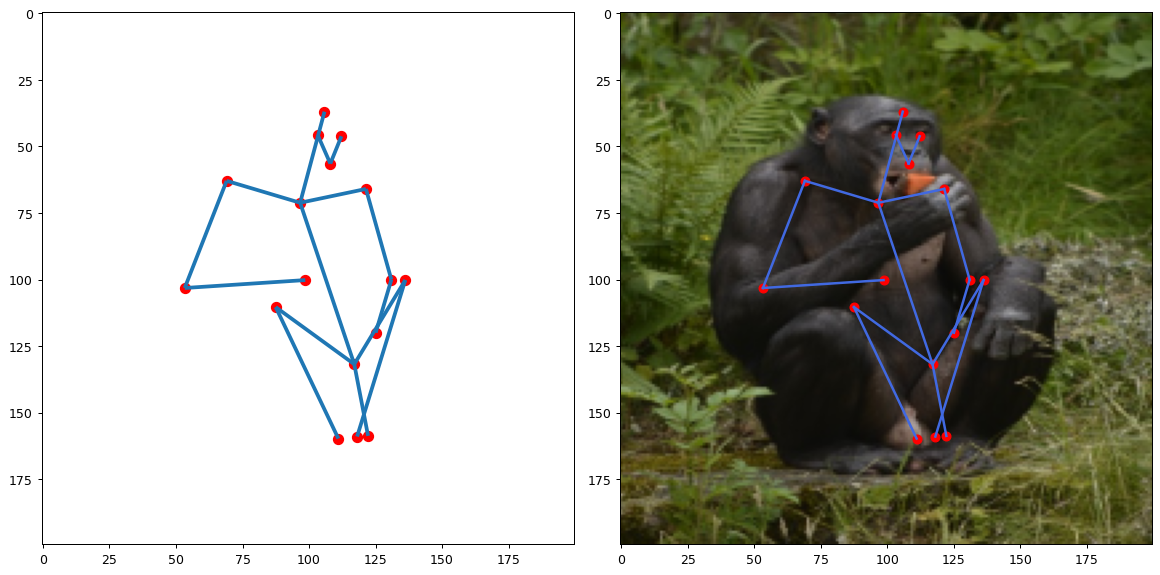

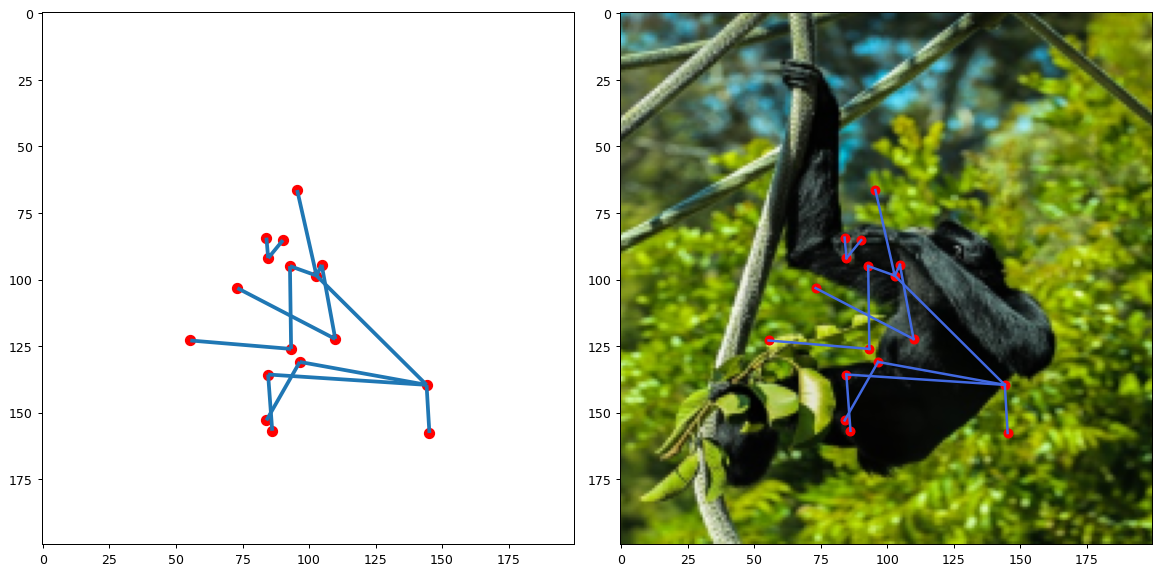

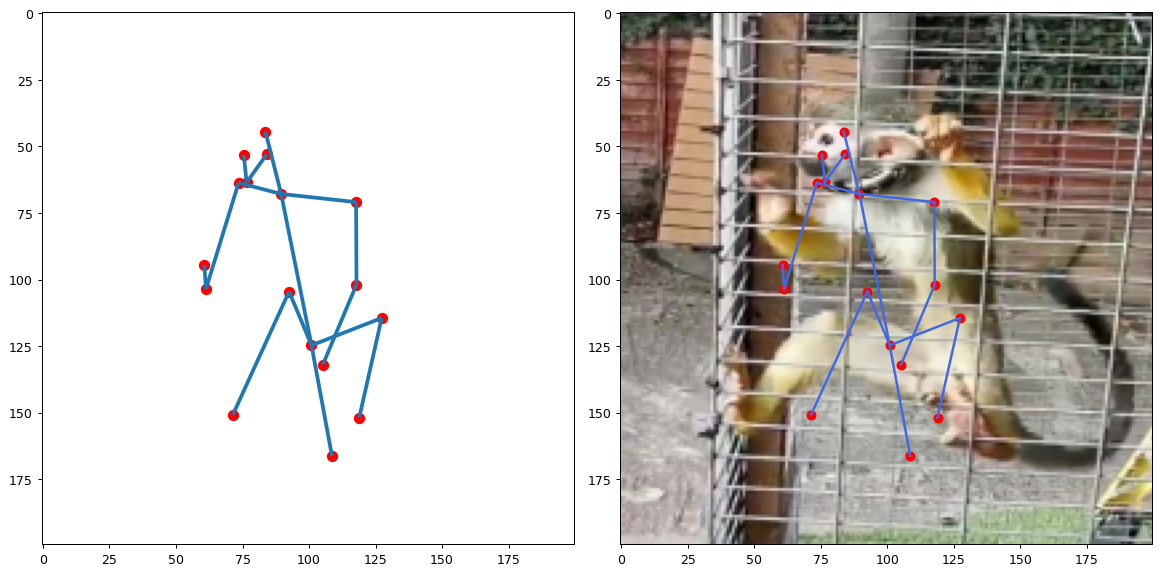

In [27]:
%matplotlib inline
for i in predl:
  j, k =i
#Plotting
  image = j
  maxim = max(image.shape[1], image.shape[2])

  plt.rc('figure', figsize=[13*image.shape[2]/(maxim), 8*image.shape[1]/(maxim)], dpi=90)

  fig, ax = plt.subplots(nrows=1, ncols=2)
  subplot_dim = (1,2)

  x, y = torch.reshape(k,(-1,2)).t()
  br , br_plot = brid_pl(k.detach().numpy())

  ax1 = plt.subplot2grid(subplot_dim, (0, 1), aspect="equal")
  ax0 = plt.subplot2grid(subplot_dim, (0, 0), aspect="equal", adjustable='box', sharex=ax1, sharey=ax1)

  lc = mc.LineCollection(br, linewidths=3)
  ax0.add_collection(lc)
  ax0.autoscale()
  ax0.scatter(x,y,s=8**2,c='red',)

  ax1.imshow(image.permute(1, 2, 0))
  ax1.scatter(x,y,s=7**2,c='red')
  ax1.plot(*br_plot, color="royalblue", linewidth=2)

  plt.tight_layout()
  plt.show()